<a href="https://colab.research.google.com/github/alisonnnnn88/programming_language/blob/main/HW1_%E6%8F%90%E6%AC%BE%E6%A9%9F%E7%B3%BB%E7%B5%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ==== 歡迎使用提款機系統 ====
📌 提款機系統使用說明
  
> 未使用過此系統之使用者，請點選【註冊】   
> 使用過則輸入帳密後點選【登入】    
> 登入後，按左上角【提款機功能】  
> 有以下幾個按鍵:新增存款金額、新增提款金額、查看餘額、清除紀錄、登出  
> 若要輸入存款 or 提款，請輸入完數字後，點選【新增存款/提款金額】  
> 若要轉帳，請輸入完目標帳號和金額後，點選【轉帳】    
> 若要查看餘額，請點選【查看餘額】  
> 若想完全清除提款機紀錄，請點選【清除紀錄】  
> 【提款機功能頁面】最底下會顯示操作結果 (如:✅ 已新增收入：200 元)   
> 若要查看提款紀錄，請點選【提款機紀錄】      

> 溫馨提醒:  
> 清除紀錄後 ⚠️不可復原⚠️   
> 支出時若金額超過餘額，會顯示「餘額不足」  


💵 提款紀錄: https://docs.google.com/spreadsheets/d/1h75idXVO6GMosL5bPUF-G76MqxOziHu1tJieRtpdkP4/edit?usp=sharing

In [3]:
!pip install gradio
import gradio as gr
import gspread
from google.colab import auth
from google.auth import default
from datetime import datetime
import pytz
import pandas as pd

# Google 認證
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# 設定 Google Sheets URL 和工作表
SPREADSHEET_URL = "https://docs.google.com/spreadsheets/d/1h75idXVO6GMosL5bPUF-G76MqxOziHu1tJieRtpdkP4/edit?usp=sharing"
sh = gc.open_by_url(SPREADSHEET_URL)

# 工作表設定
user_ws = sh.worksheet("使用者資料表")
record_ws = sh.worksheet("交易紀錄表")

# 設定登入系統
current_user = None

# 註冊用戶
def handle_register(username, password):
    users = [str(u).strip() for u in user_ws.col_values(1) if u is not None]

    if username in users:
        return "⚠️ 帳號已存在"
    else:
        user_ws.append_row([username, password])
        return f"✅ 註冊成功，請登入"

# 登入系統
def handle_login(username, password):
    global current_user
    users_dict = {str(row['使用者名稱']).strip(): str(row['密碼']).strip()
                  for row in user_ws.get_all_records() if row['使用者名稱'] is not None}

    if username in users_dict and users_dict[username] == password:
        current_user = username
        return f"✅ 登入成功，歡迎 {username}！\n請選擇操作"
    else:
        return "❌ 帳號或密碼錯誤"

# 輸入收入
def handle_income(income):
    if current_user is None:
        return "❌ 請先登入"
    if int(income) <= 0:
        return "❌ 輸入金額需大於0，請重新輸入"
    tz = pytz.timezone("Asia/Taipei")
    now = datetime.now(tz)
    df = pd.DataFrame(record_ws.get_all_records())
    if not df.empty:
        df.columns = df.columns.str.strip()
    user_df = df[df["使用者名稱"] == current_user] if not df.empty else pd.DataFrame()
    previous_balance = float(user_df.iloc[-1]["餘額"]) if not user_df.empty else 0.0
    new_balance = previous_balance + int(income)
    record_ws.append_row([current_user, now.strftime("%Y-%m-%d"), now.strftime("%H:%M:%S"),
                          int(income), 0, new_balance])
    return f"✅ 已新增存款金額：{income} 元"

# 輸入支出
def handle_expense(expense):
    if current_user is None:
        return "❌ 請先登入"
    amount = int(expense)
    if amount <= 0:
        return "❌ 輸入金額需大於0，請重新輸入"
    df = pd.DataFrame(record_ws.get_all_records())
    if not df.empty:
        df.columns = df.columns.str.strip()
    user_df = df[df["使用者名稱"] == current_user] if not df.empty else pd.DataFrame()
    balance = float(user_df.iloc[-1]["餘額"]) if not user_df.empty else 0.0
    if amount > balance:
        return "❌ 餘額不足！"
    else:
        tz = pytz.timezone("Asia/Taipei")
        now = datetime.now(tz)
        new_balance = balance - amount
        record_ws.append_row([current_user, now.strftime("%Y-%m-%d"), now.strftime("%H:%M:%S"),
                              0, amount, new_balance])
        return f"✅ 已新增提款金額：{amount} 元"

# 查看餘額
def handle_balance():
    if current_user is None:
        return "❌ 請先登入"
    df = pd.DataFrame(record_ws.get_all_records())
    if not df.empty:
        df.columns = df.columns.str.strip()
    user_df = df[df["使用者名稱"] == current_user] if not df.empty else pd.DataFrame()
    balance = int(float(user_df.iloc[-1]["餘額"])) if not user_df.empty else 0
    return f"💰 您目前的餘額為：{balance} 元"


# 轉帳功能
def handle_transfer(target_user, amount):
    global current_user
    if current_user is None:
        return "❌ 請先登入"

    # 金額檢查
    amount = int(amount)
    if amount <= 0:
        return "❌ 轉帳金額需大於0，請重新輸入"

    # 確認目標帳號存在
    users = [str(u).strip() for u in user_ws.col_values(1) if u is not None]
    if target_user not in users:
        return "❌ 目標帳號不存在，請確認帳號是否正確"

    # 取出目前使用者餘額
    df = pd.DataFrame(record_ws.get_all_records())
    if not df.empty:
        df.columns = df.columns.str.strip()
    user_df = df[df["使用者名稱"] == current_user] if not df.empty else pd.DataFrame()
    balance = float(user_df.iloc[-1]["餘額"]) if not user_df.empty else 0.0

    if amount > balance:
        return "❌ 餘額不足，無法轉帳"

    # 時間戳記
    tz = pytz.timezone("Asia/Taipei")
    now = datetime.now(tz)

    # 更新轉出者餘額
    new_balance_sender = balance - amount
    record_ws.append_row([current_user, now.strftime("%Y-%m-%d"), now.strftime("%H:%M:%S"),
                          0, 0, amount, new_balance_sender])  # 👈 存款=0, 提款=0, 轉帳=金額

    # 更新收款者餘額
    target_df = df[df["使用者名稱"] == target_user] if not df.empty else pd.DataFrame()
    target_balance = float(target_df.iloc[-1]["餘額"]) if not target_df.empty else 0.0
    new_balance_receiver = target_balance + amount
    record_ws.append_row([target_user, now.strftime("%Y-%m-%d"), now.strftime("%H:%M:%S"),
                          amount, 0, 0, new_balance_receiver])  # 👈 存款=金額, 其他=0

    return f"✅ 轉帳成功！您已轉出 {amount} 元給 {target_user}\n💰 您的新餘額為：{int(new_balance_sender)} 元"


# 清除紀錄
def handle_clear():
    global current_user
    if current_user is None:
        return "❌ 請先登入"
    df = pd.DataFrame(record_ws.get_all_records())
    if not df.empty:
        df.columns = df.columns.str.strip()
    new_df = df[df["使用者名稱"] != current_user] if not df.empty else pd.DataFrame()
    record_ws.clear()
    record_ws.append_row(["使用者名稱", "日期", "時間", "存款", "提款", "轉帳", "餘額"])
    for row in new_df.values.tolist():
        record_ws.append_row(row)
    return "🗑️ 已清除您的所有紀錄"

# 登出功能
def handle_logout():
    global current_user
    current_user = None
    return "👋 已登出！請重新登入"

# 查看交易紀錄
def handle_records():
    if current_user is None:
        return pd.DataFrame([["❌ 請先登入"]], columns=["訊息"])

    df = pd.DataFrame(record_ws.get_all_records())
    if not df.empty:
        df.columns = df.columns.str.strip()
    user_df = df[df["使用者名稱"] == current_user] if not df.empty else pd.DataFrame()

    if user_df.empty:
        return pd.DataFrame([["尚無紀錄"]], columns=["訊息"])

    return user_df[["日期", "時間", "存款", "提款", "轉帳", "餘額"]]

# Gradio UI
def gradio_interface():
    with gr.Blocks() as demo:
        with gr.Tab("登入"):
            username_input = gr.Textbox(label="帳號")
            password_input = gr.Textbox(label="密碼", type="password")
            login_btn = gr.Button("登入")
            register_btn = gr.Button("註冊")
            output_login = gr.Textbox(label="登入結果")

            login_btn.click(handle_login, inputs=[username_input, password_input], outputs=output_login)
            register_btn.click(handle_register, inputs=[username_input, password_input], outputs=output_login)

        with gr.Tab("提款機功能"):
            balance_btn = gr.Button("查看餘額")
            income_input = gr.Number(label="存款金額")
            income_btn = gr.Button("新增存款金額")
            expense_input = gr.Number(label="提款金額")
            expense_btn = gr.Button("新增提款金額")

            # 轉帳功能
            target_user_input = gr.Textbox(label="轉帳目標帳號")
            transfer_input = gr.Number(label="轉帳金額")
            transfer_btn = gr.Button("轉帳")

            clear_btn = gr.Button("清除紀錄")
            logout_btn = gr.Button("登出")
            output = gr.Textbox(label="操作結果")

            balance_btn.click(handle_balance, outputs=output)
            income_btn.click(handle_income, inputs=[income_input], outputs=output)
            expense_btn.click(handle_expense, inputs=[expense_input], outputs=output)
            transfer_btn.click(handle_transfer, inputs=[target_user_input, transfer_input], outputs=output)
            clear_btn.click(handle_clear, outputs=output)
            logout_btn.click(handle_logout, outputs=output)

        with gr.Tab("提款機紀錄"):
            records_btn = gr.Button("刷新紀錄")
            records_table = gr.Dataframe(headers=["使用者名稱", "日期", "時間", "存款", "提款", "轉帳", "餘額"], label="交易紀錄")

            records_btn.click(handle_records, outputs=records_table)

    return demo

# 啟動 Gradio 應用
demo = gradio_interface()
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4bfc06aca4ddb5643a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


-- **操作畫面** --
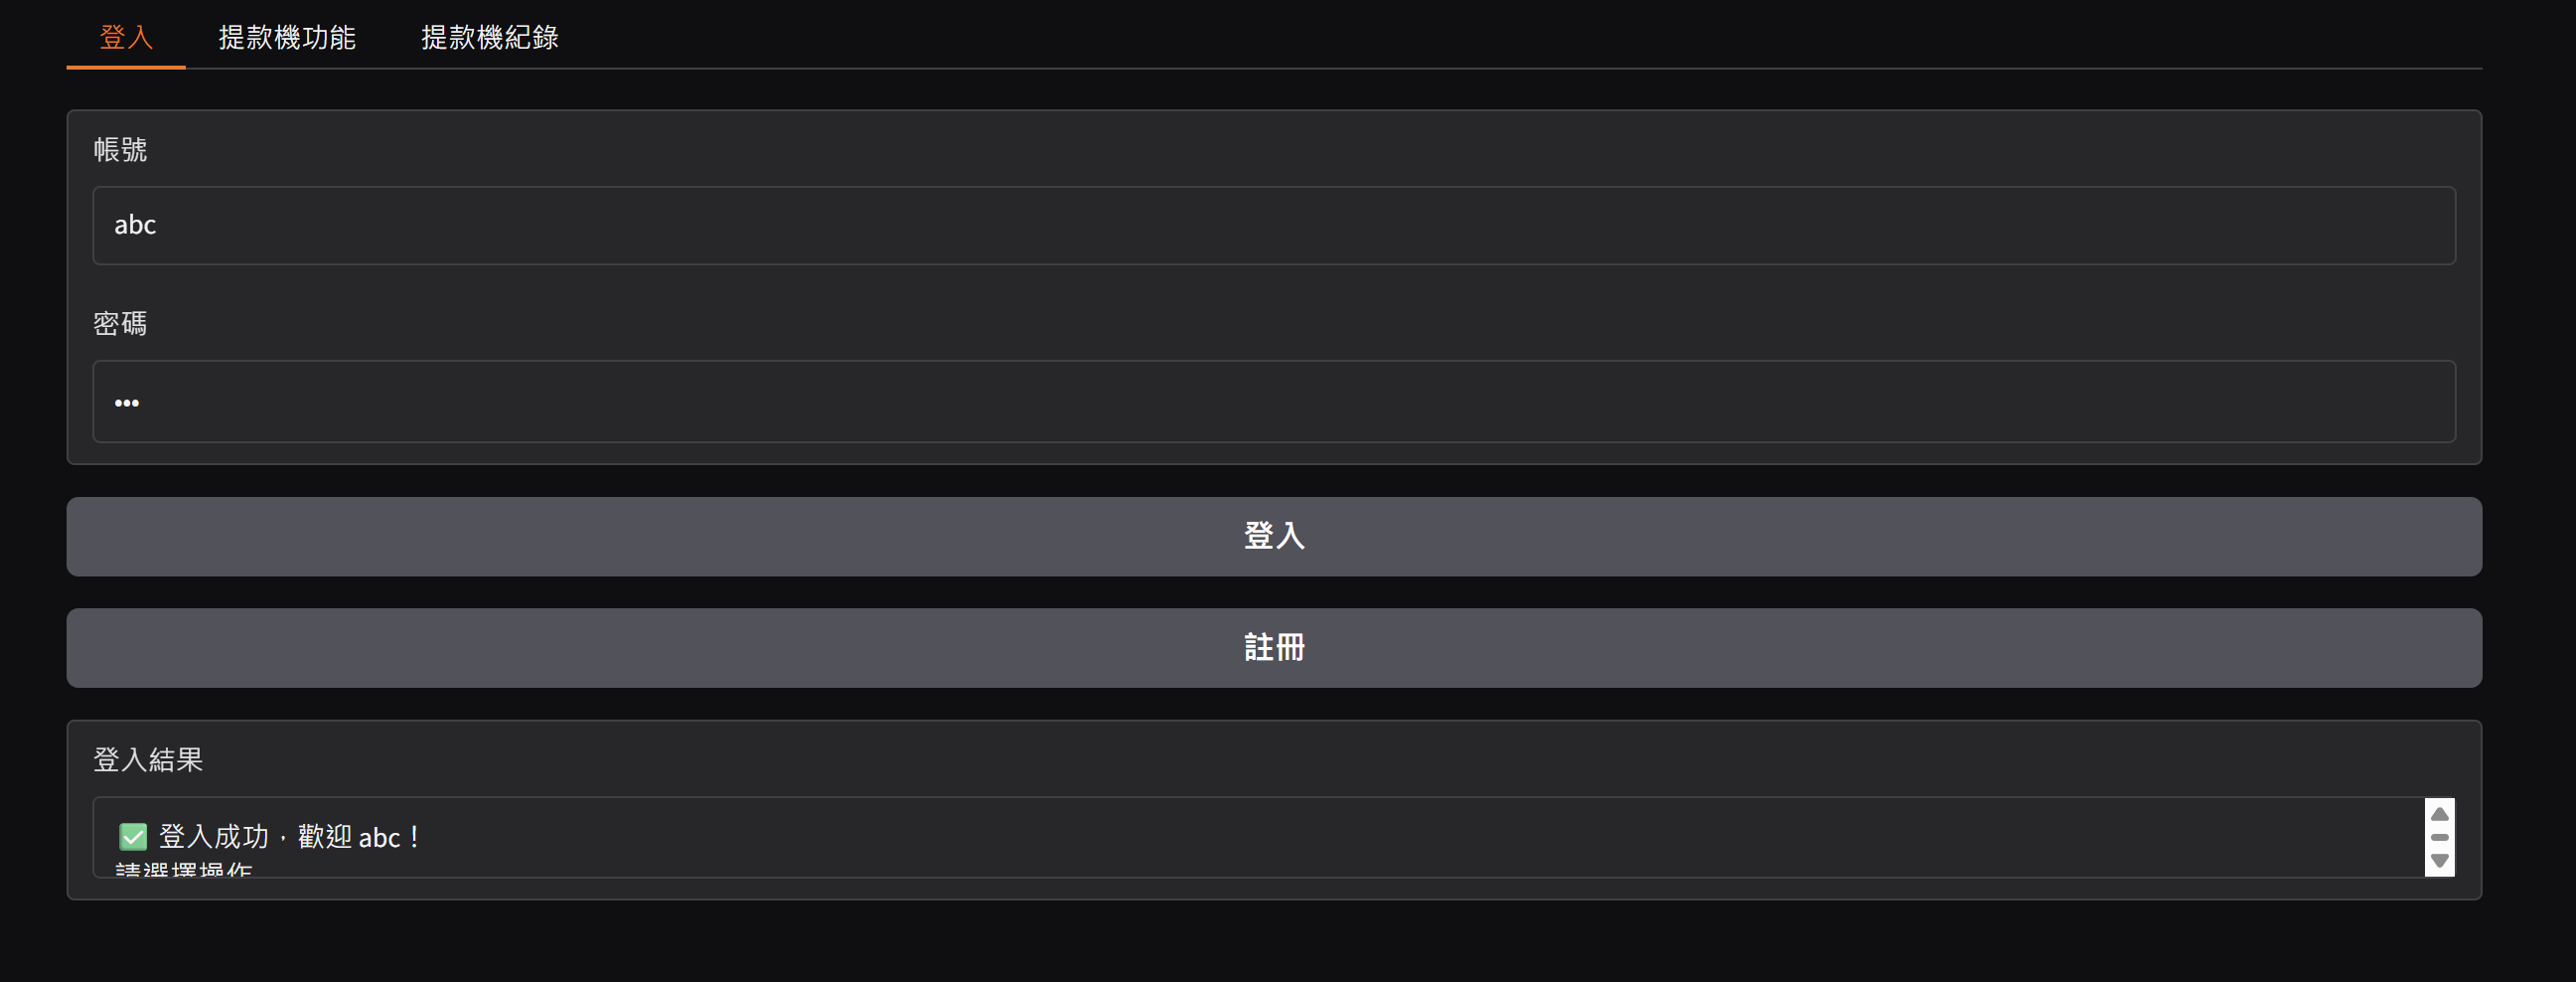
若已有帳號，請按【登入】; 沒有則按【註冊】再按【登入】
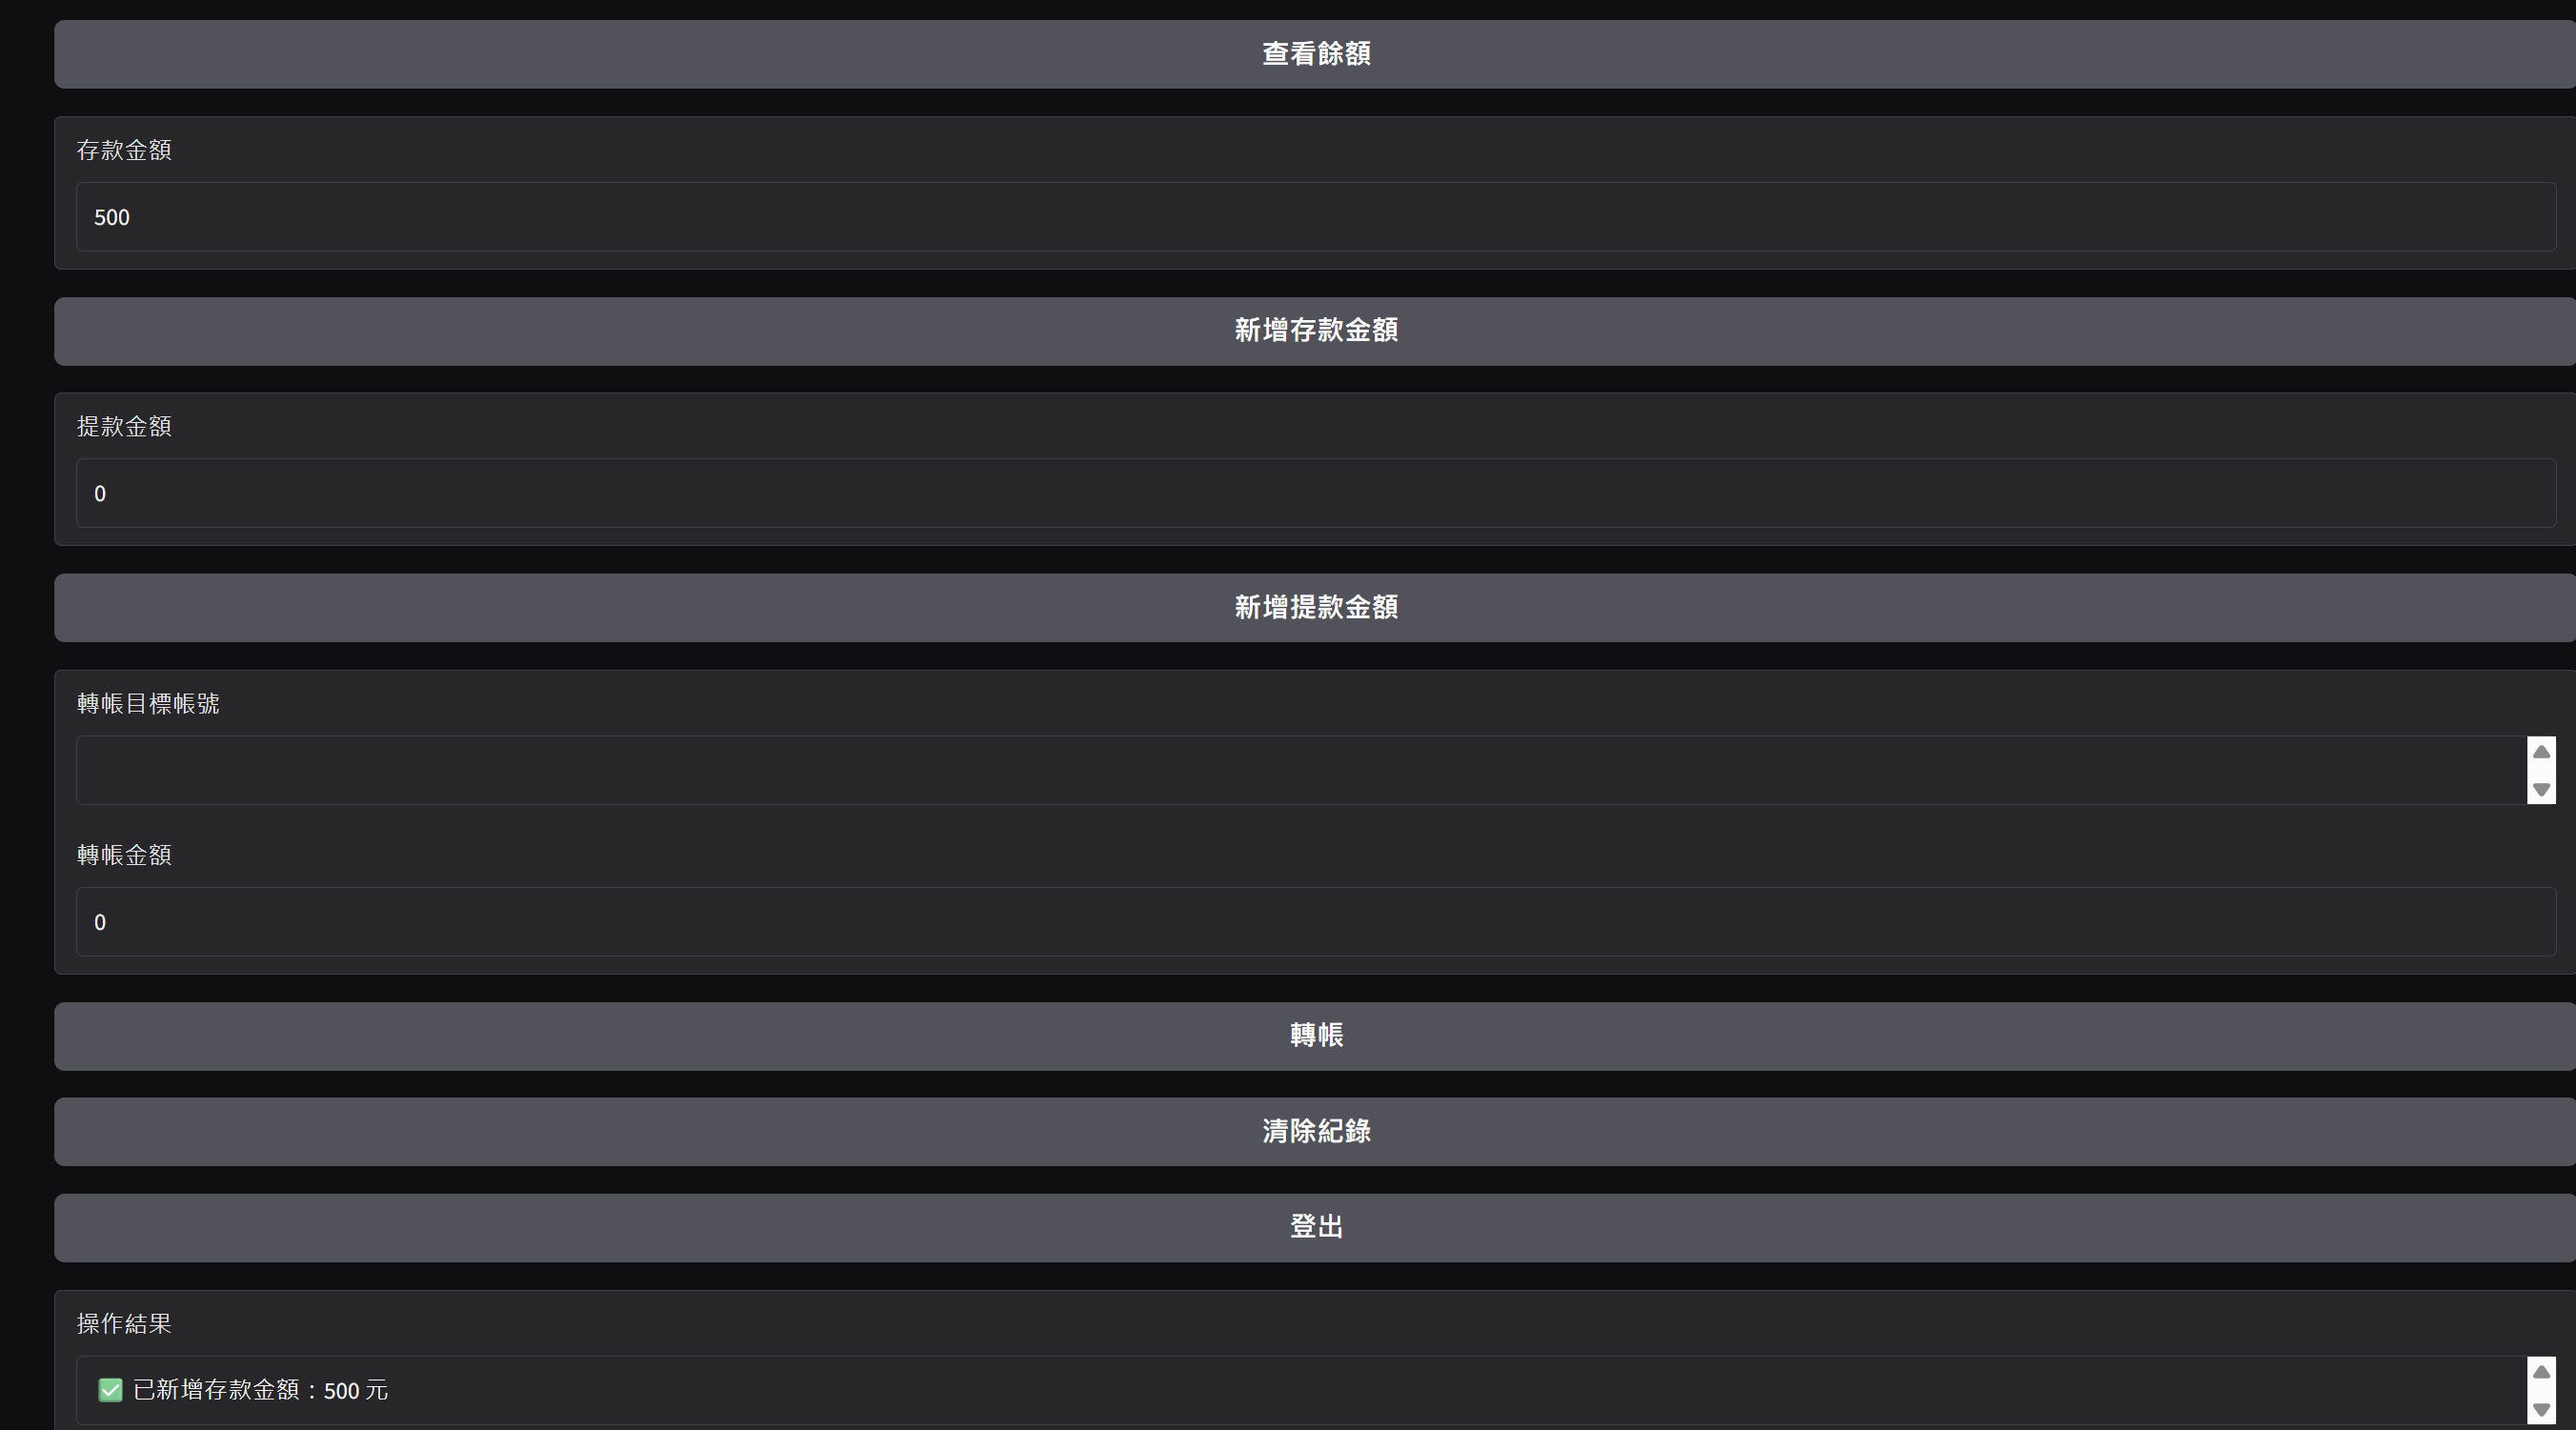
存款畫面
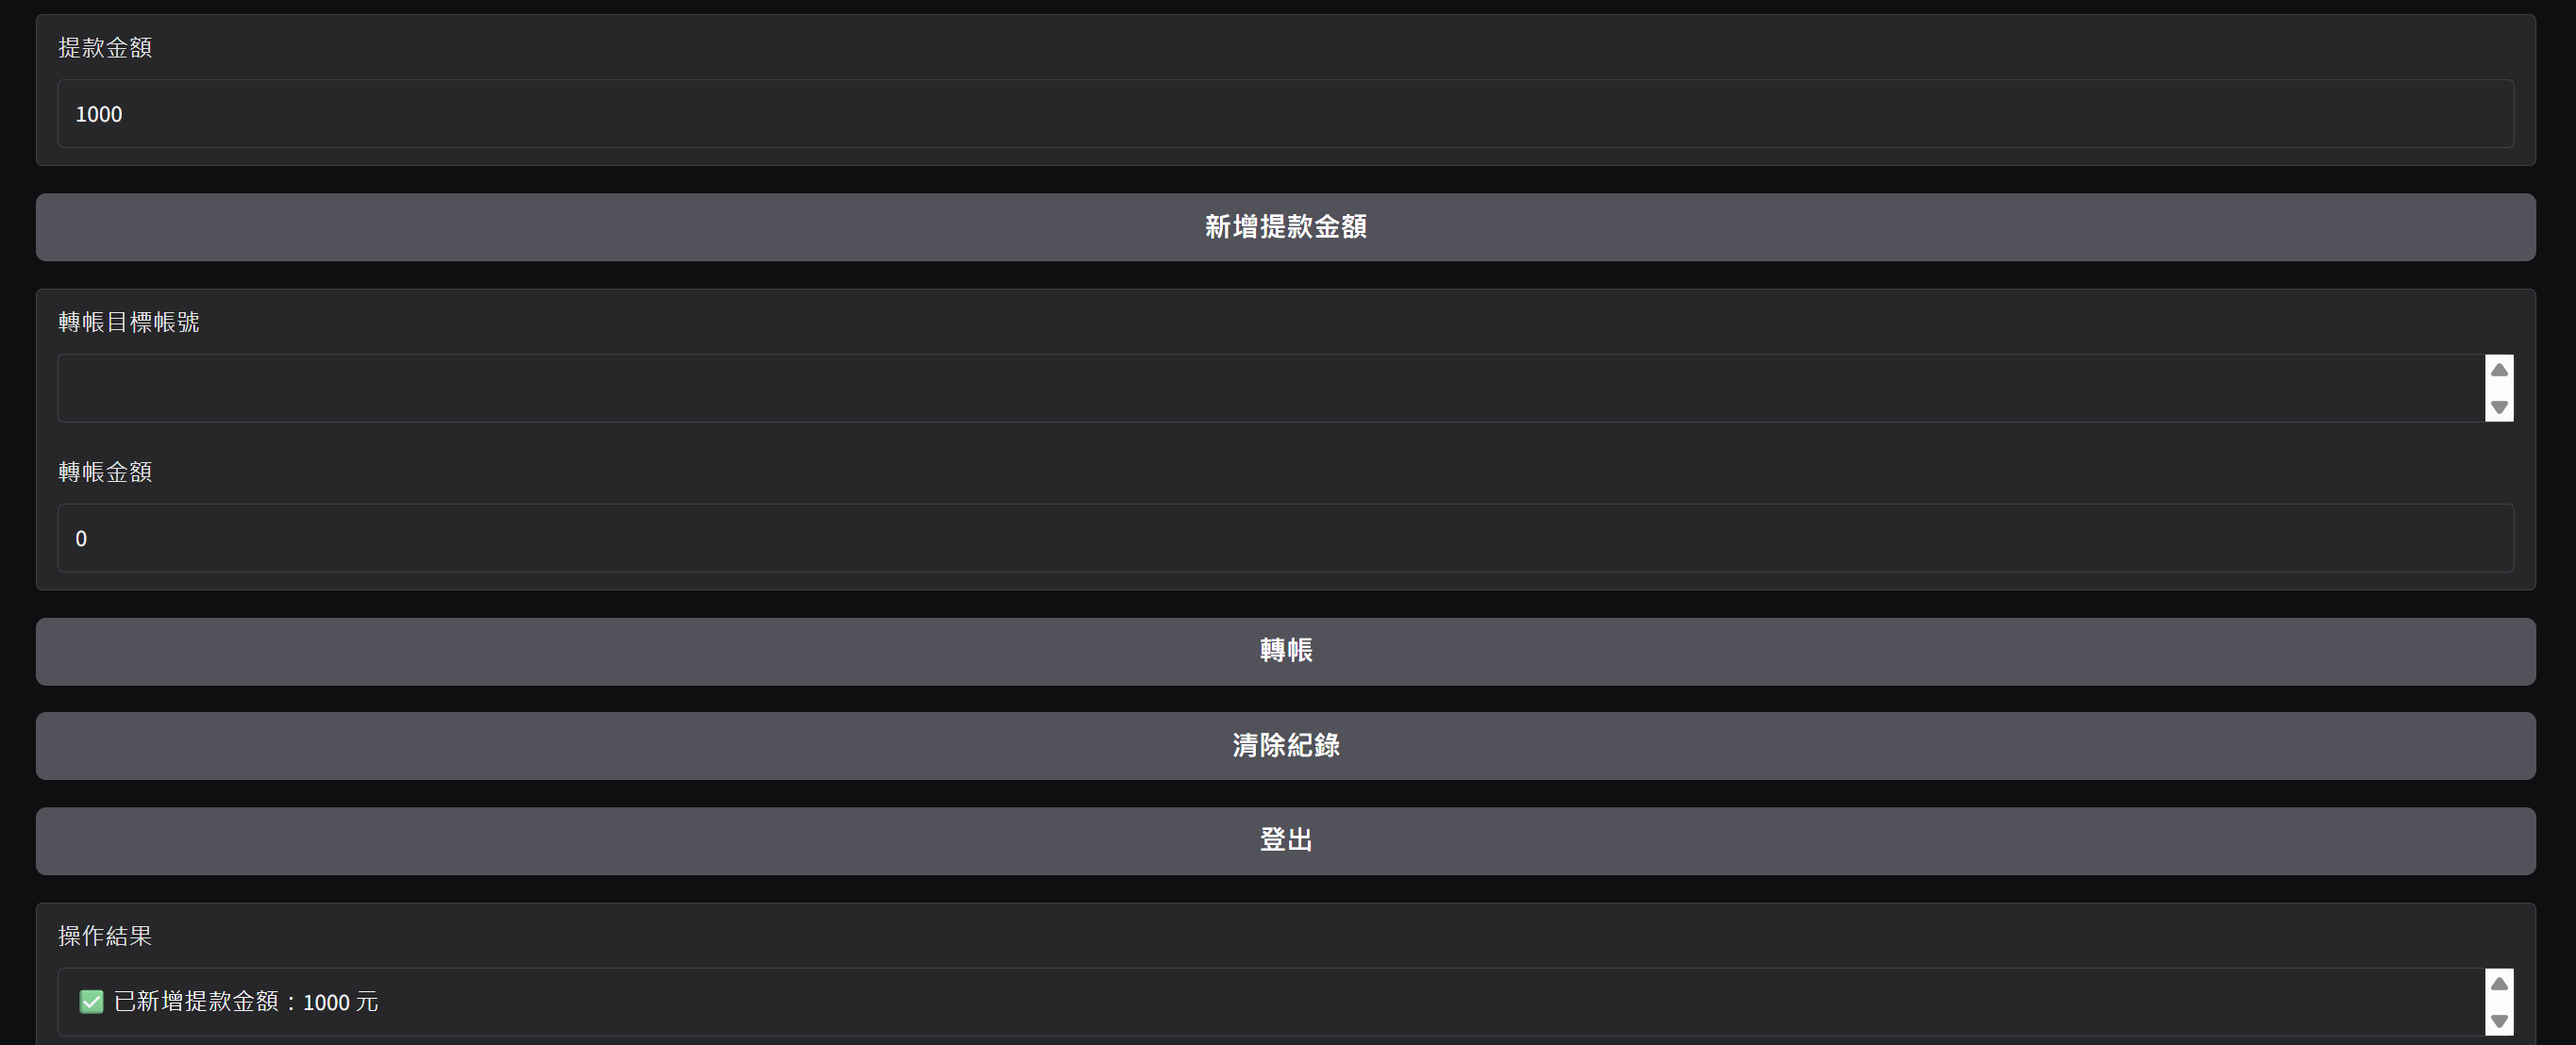
提款畫面
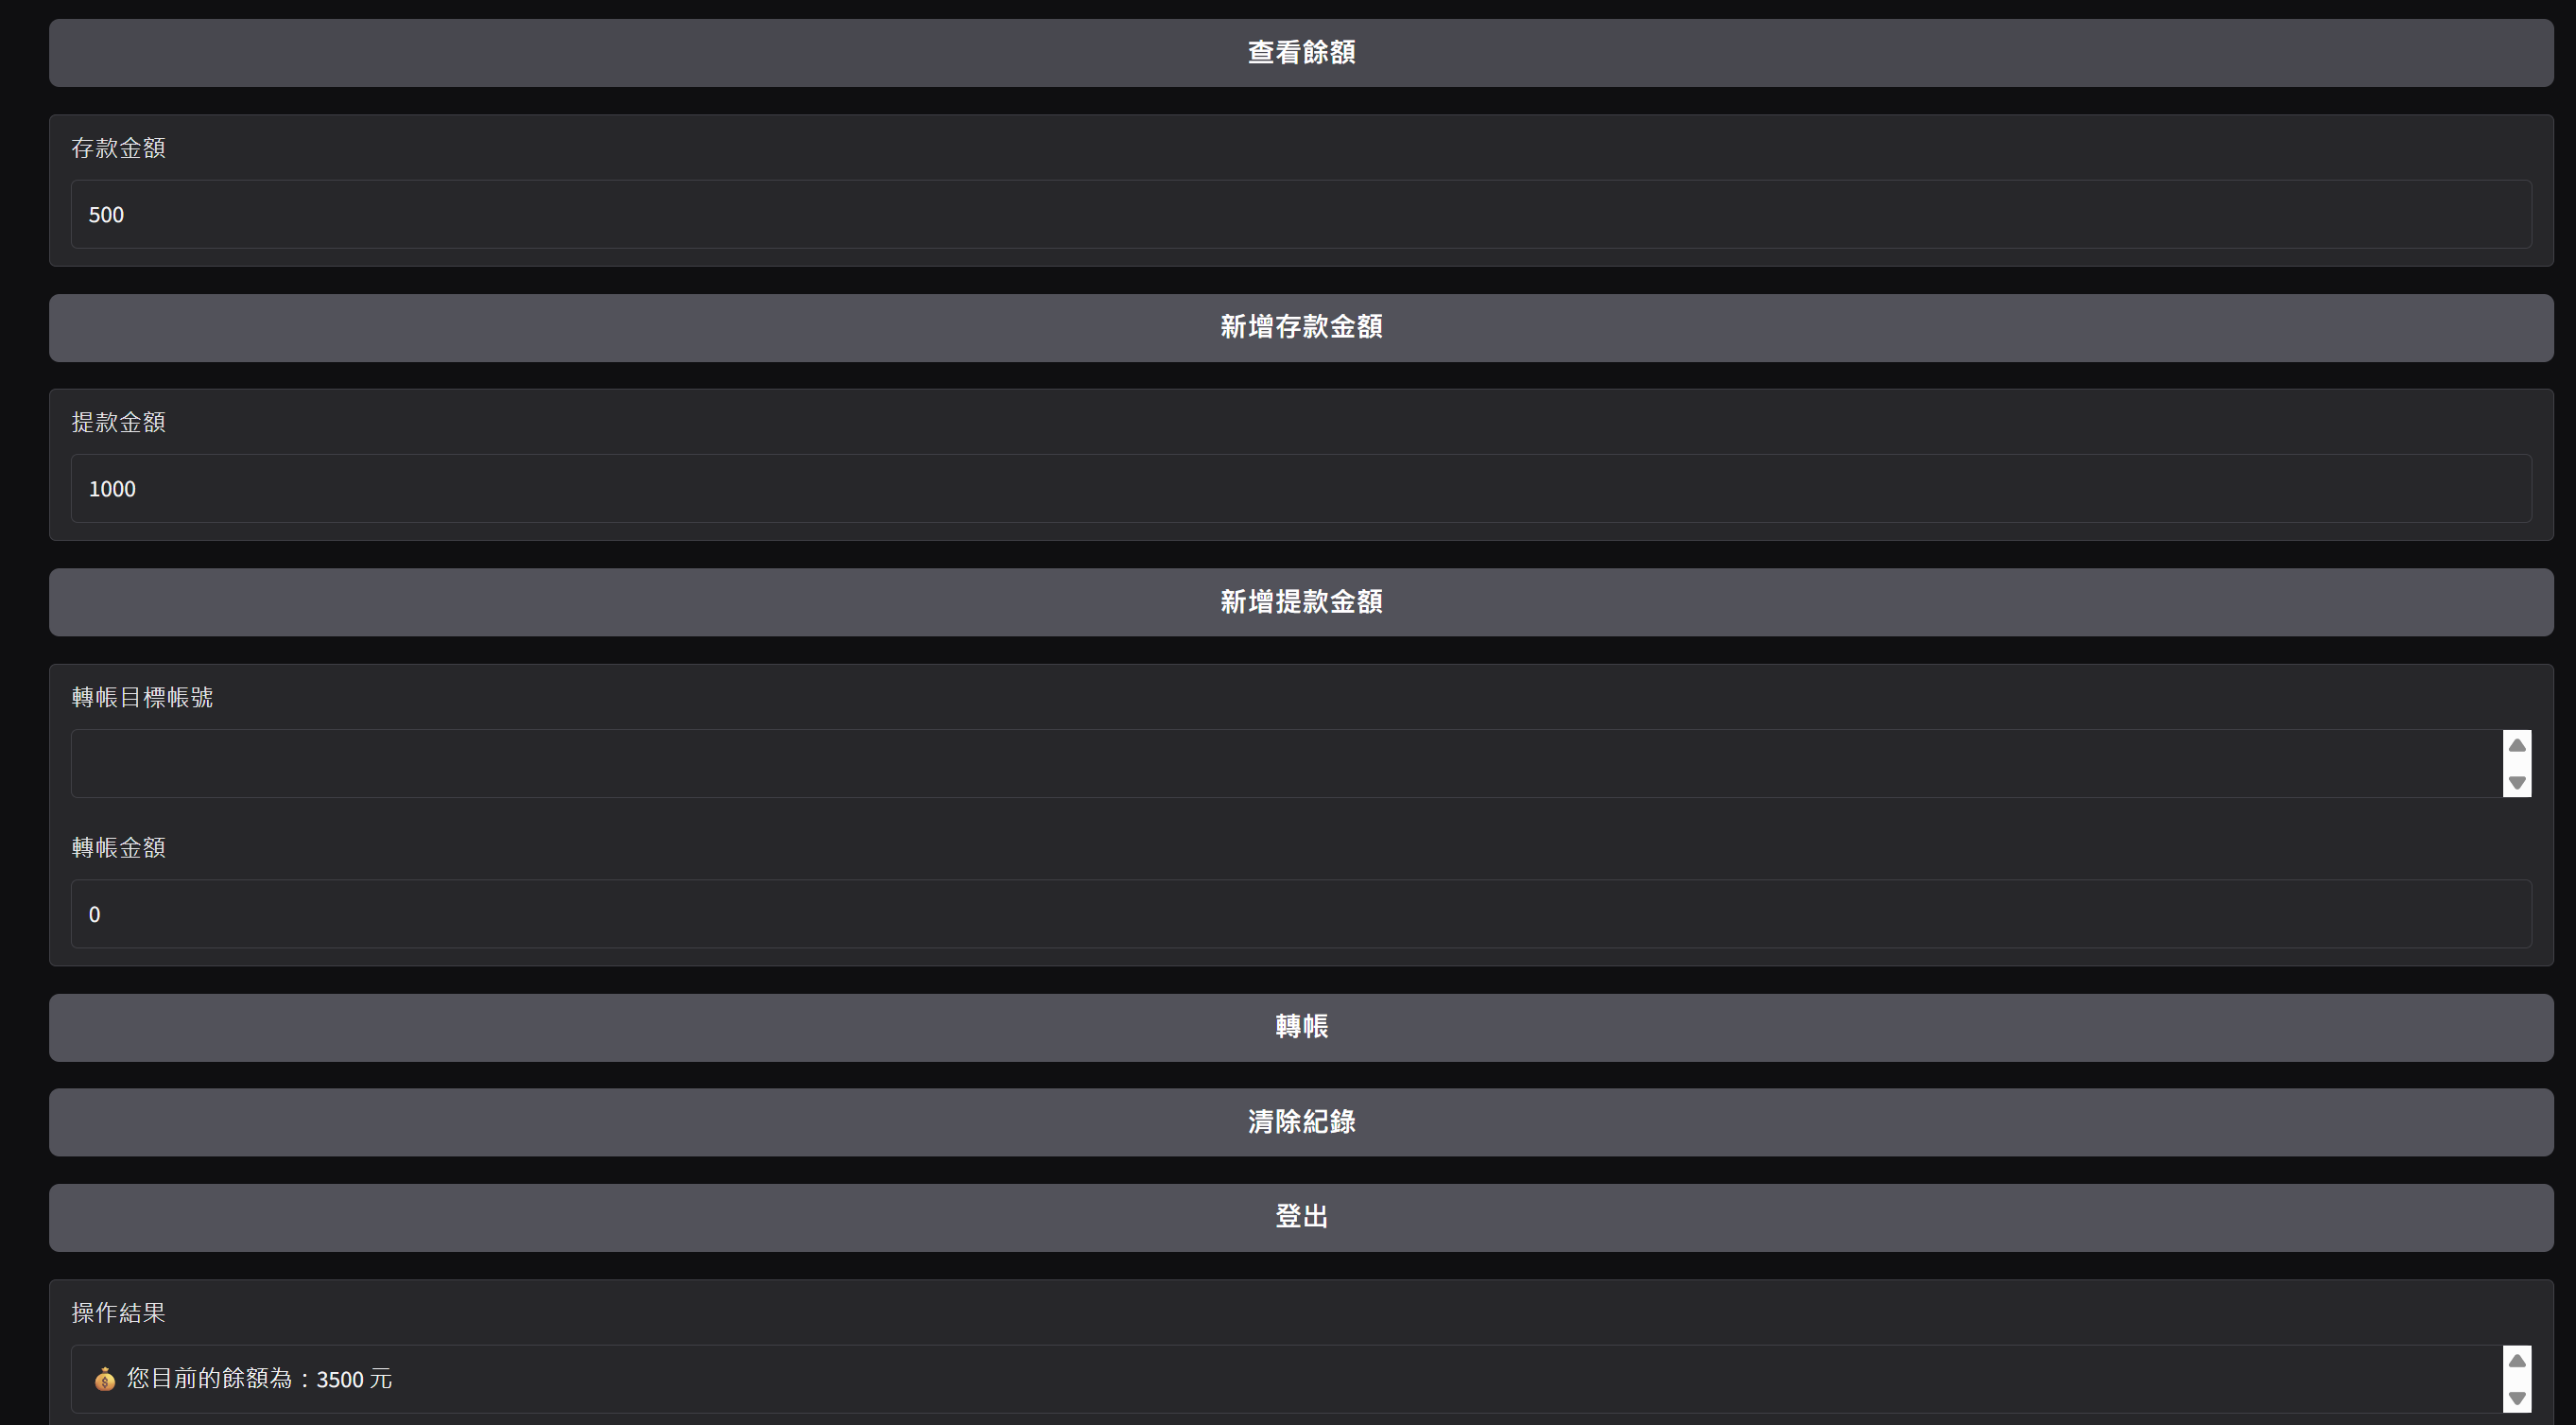
查看餘額
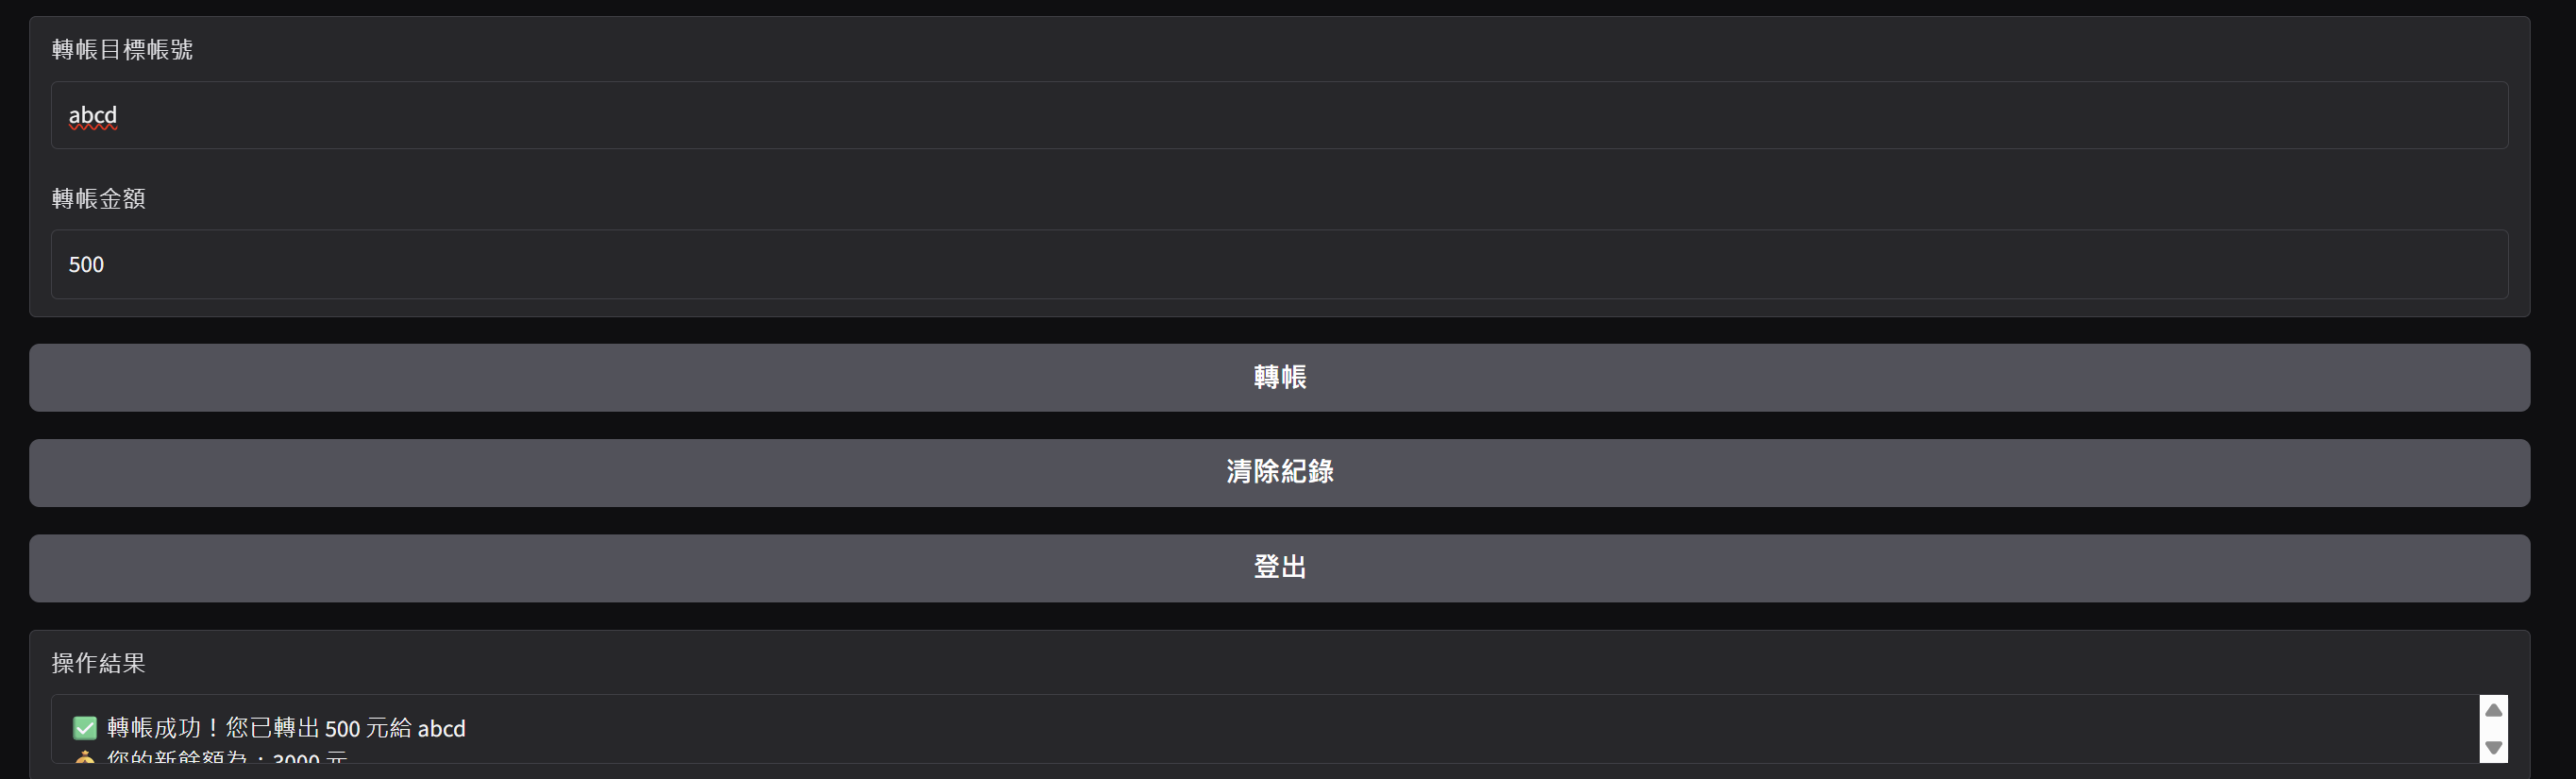
轉帳畫面
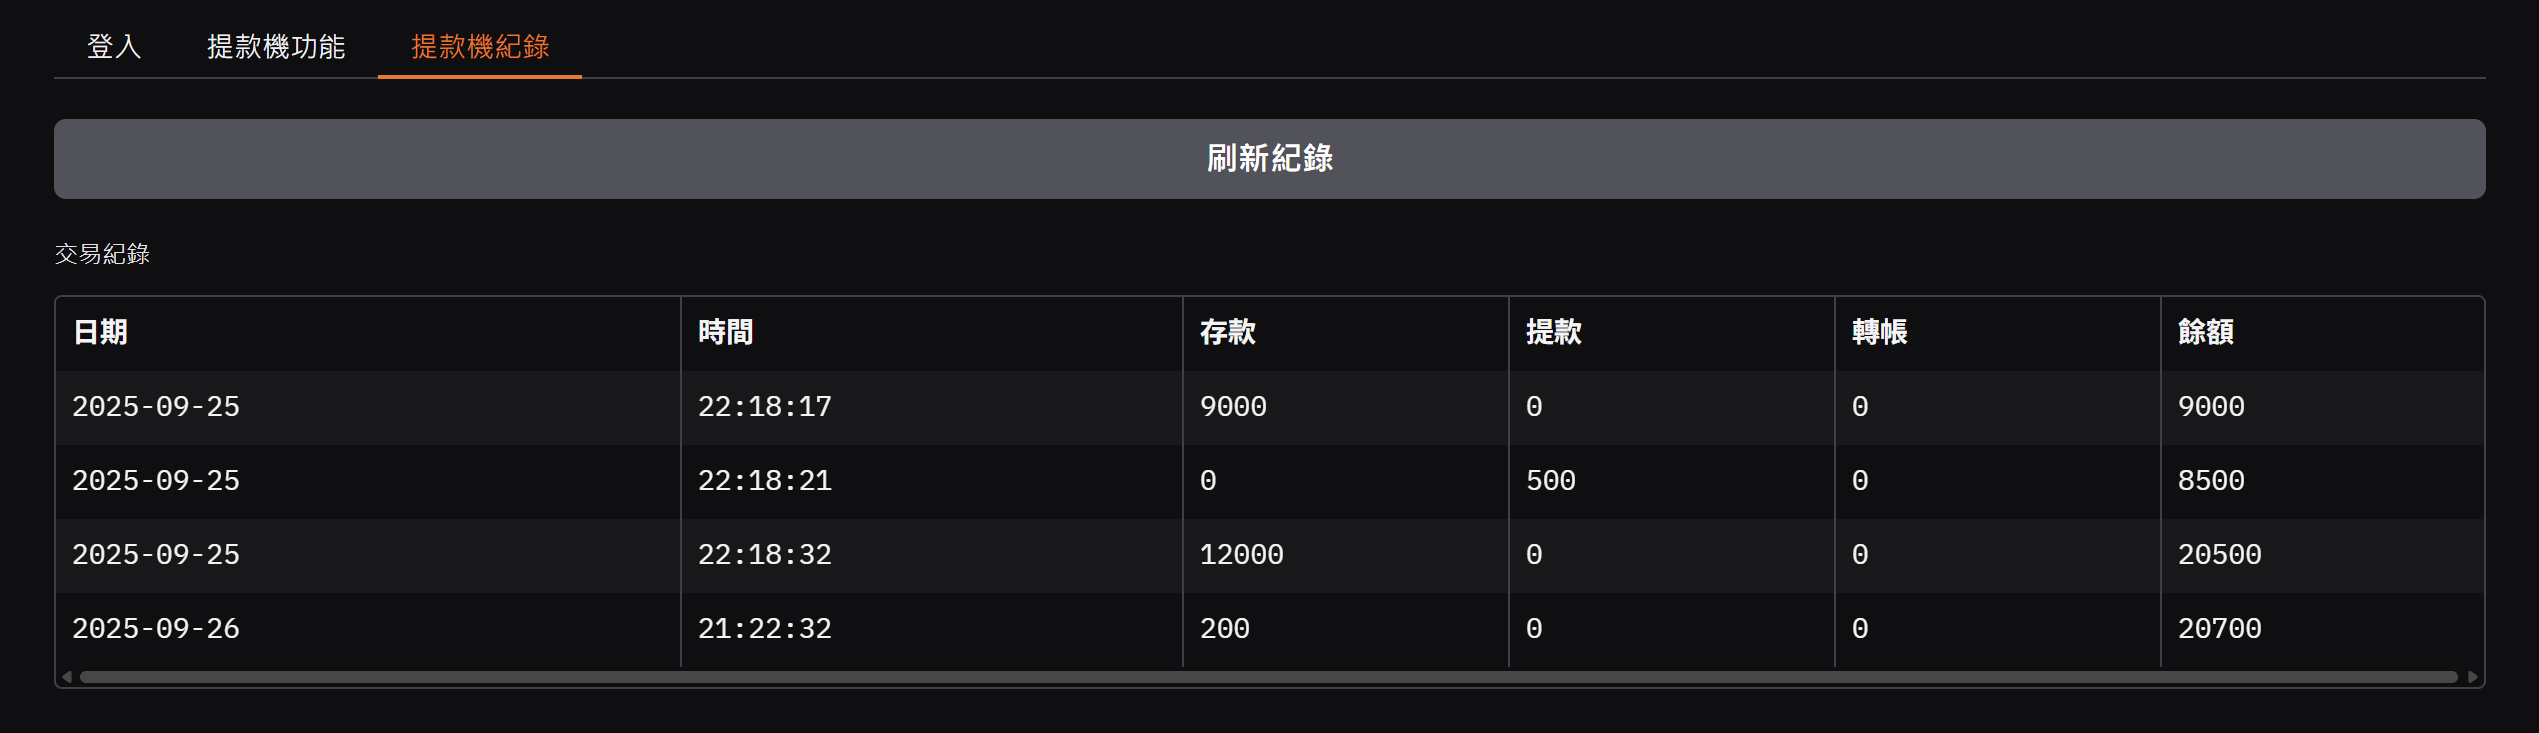
提款機紀錄